This is the end result of my implementation for the Project 5.

Vehicle Detection Project

The goals / steps of this project are the following:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
Estimate a bounding box for vehicles detected.

In [18]:
# Importing libraries
import os
import cv2
import math
import glob
import time
import random
import numpy as np
import matplotlib.image as mpimg
from skimage.feature import hog
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
%matplotlib inline

To prevent hardcoding, I ddefine three functions to compute hog features, perform spatial binning and extract color histograms.

For hog_feat() function I used the hog() function from scikit-image module and left the all variable undifined to leave wiggle room for different atributes to finetune final output of the model.

For performing spatial binning I just used resize() in binn_spat() from opencv and raveled data into a vector.

For extracting color histograms I used np.histogram() function and then stacked them all in an ordered array.

Finally I defined a function that conductes all three feature extractions. This will allow me to easily alter the way I extract features from training set by just changing few attribute numbers.

In [19]:
def hog_feat(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Calls with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise calls with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# A function to compute binned color features  
def binn_spat(img, size=(32, 32)):
    # Create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Returning feature vector
    return features

# A function to compute color histogram features 
def color_histogram(img, nbins=32):
    # Compute histograms
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Stack histograms in order
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Returns the individual histograms, bin_centers and feature vector
    return hist_features

# A function to extract features from a list of images.
def extract_feat(imgs, color_space='RGB', spatial_size=(64, 64),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, feature_hog=True):
    # Final output list
    features = []
    # Iterates through all images
    for img in imgs:
        image_features = []
        # Reads in each one by one
        image = mpimg.imread(img)
        # applies color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        #Perform spatial binnig
        if spatial_feat == True:
            spatial_features = binn_spat(feature_image, size=spatial_size)
            image_features.append(spatial_features)
        # Perform histogram extraction
        if hist_feat == True:
            hist_features = color_histogram(feature_image, nbins=hist_bins)
            image_features.append(hist_features)
        # Hog features
        if feature_hog == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(hog_feat(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = hog_feat(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append all three features
            image_features.append(hog_features)
        # Append features of all images    
        features.append(np.concatenate(image_features))
    return features


Here I read all images provided and add them all in two list of vehicles and not_vehicles. At the end I read one image per list randomly, perform hog extraction and visualize them to compare the outcome of feature extraction visually between vehicle and not_vehicle lists. 

In [20]:
#reading all images, vehicles and non-vehicles
img_Kitti = glob.glob('vehicles/KITTI_extracted/*.png')
img_GTIFar = glob.glob('vehicles/GTI_Far/*.png')
img_GTILeft = glob.glob('vehicles/GTI_Left/*.png')
img_GTIMiddleClose = glob.glob('vehicles/GTI_MiddleClose/*.png')
img_GTIRight = glob.glob('vehicles/GTI_Right/*.png')
img_extra = glob.glob('non-vehicles/Extras/*.png')
img_GTI = glob.glob('non-vehicles/GTI/*.png')
# List of vehicles
vehicles = []
vehicles.extend(img_Kitti)
vehicles.extend(img_GTIFar)
vehicles.extend(img_GTILeft)
vehicles.extend(img_GTIMiddleClose)
vehicles.extend(img_GTIRight)
# List of not_vehicles
not_vehicles = []
not_vehicles.extend(img_extra)
not_vehicles.extend(img_GTI)

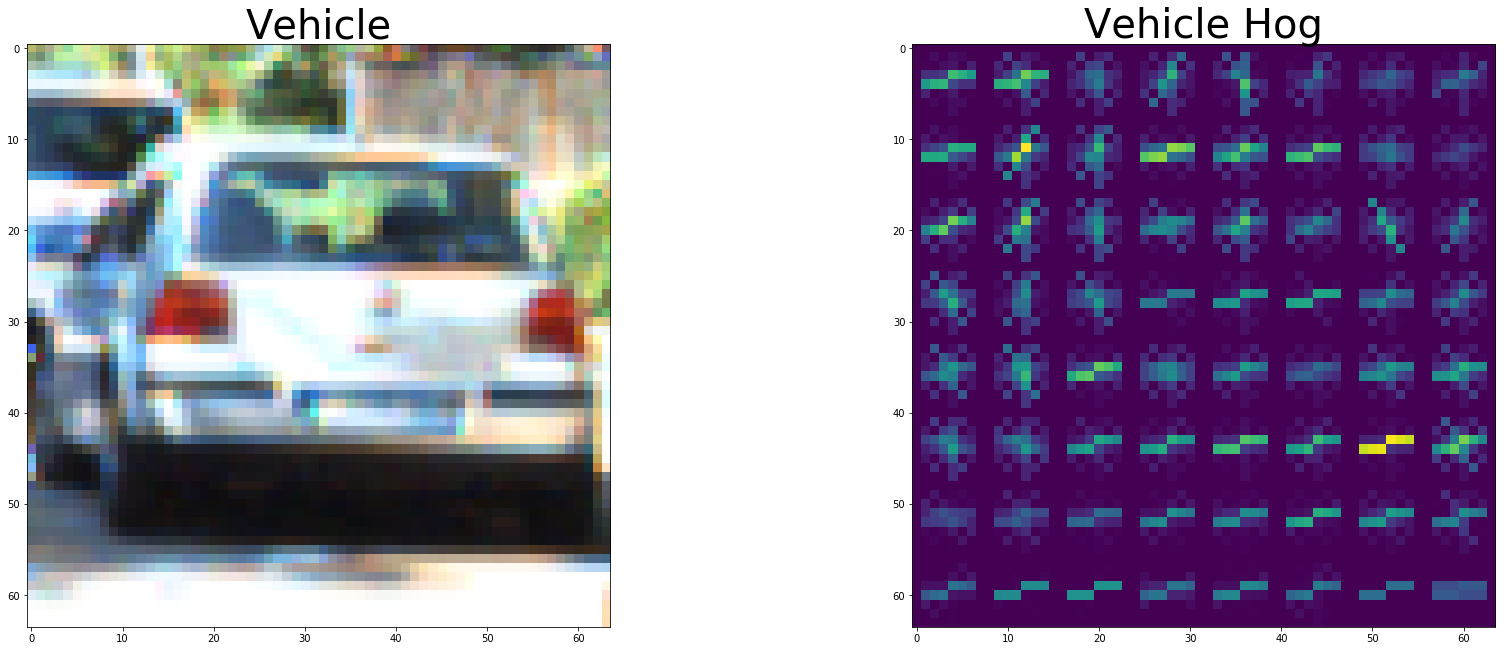

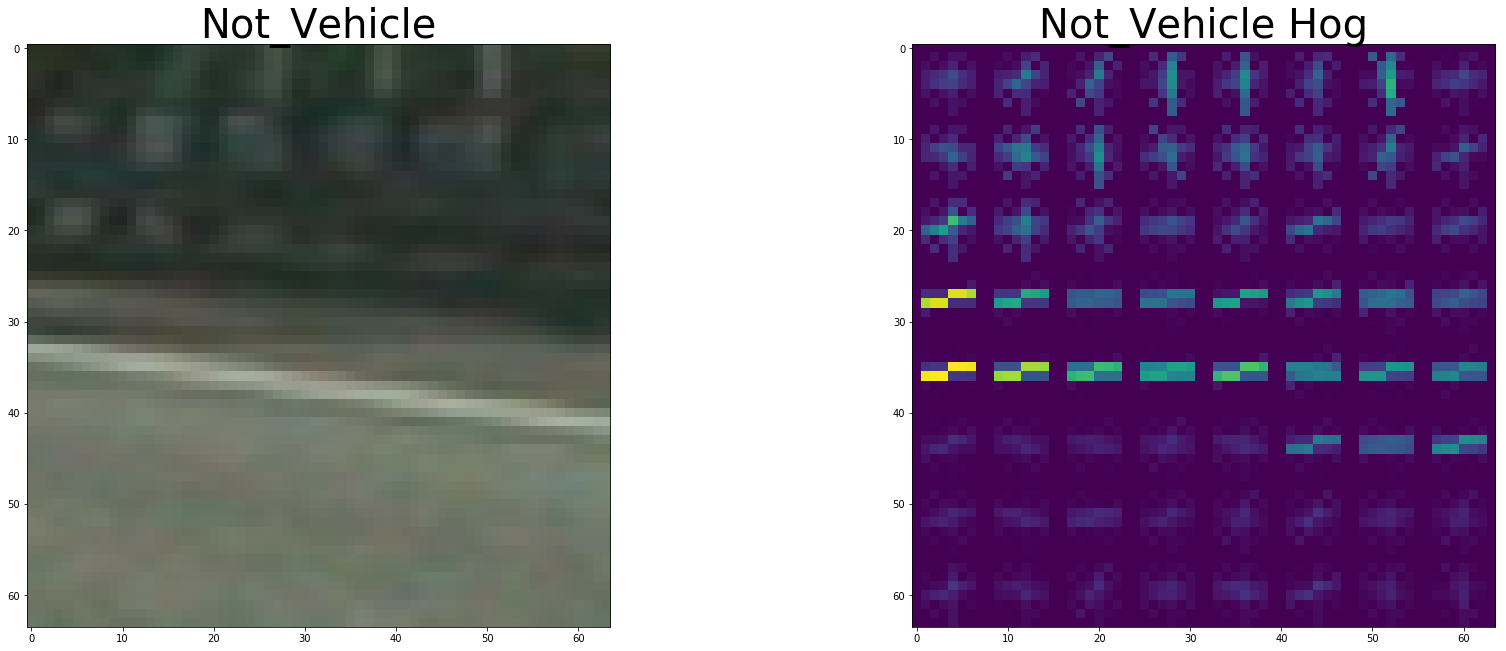

In [23]:
img_vehicles = mpimg.imread(random.choice(vehicles))
img_not_vehicles = mpimg.imread(random.choice(not_vehicles))
car_featur,hog_vehicle_img=hog_feat(img_vehicles[:,:,0],orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
notcar_featur,hog_not_vehicles_img=hog_feat(img_not_vehicles[:,:,0],orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)

#Showing Car image and related HOG

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_vehicles)
ax1.set_title('Vehicle', fontsize=40)
ax2.imshow(hog_vehicle_img)
ax2.set_title('Vehicle Hog', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Showing NotCar image and related HOG
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_not_vehicles)
ax1.set_title('Not_Vehicle', fontsize=40)
ax2.imshow(hog_not_vehicles_img)
ax2.set_title('Not_Vehicle Hog', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Next cell is where I defined all attributes of feature extraction to adjust during training if needed. I also provided a quick guide on inputs each attribue can take.

In [24]:
# Feature Extractoin attributes
color_space = 'YCrCb' # Color Space RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Channels 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning 
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features True or False
hist_feat = True # Histogram features True or False
feature_hog = True # HOG features True or False

In [25]:
print(len(vehicles), len(not_vehicles))

8792 8968


Next I first extracted all features for both vehicles and not_vehicles. Then we will standardize scales for all features to float64 to domination by a specific feature. To do so I use the StandardScalar() from sklearn library. This function removes features mean and scales to unit variance. To do the scaling first I computed the mean and standard deviation using the fit() method, then with transform() method did the standardization with scaling and centring. To use the final output I stacked all standardized features hoizontally, then using the sklearn train_test_split() function, I created a test set by splitting 20% of the dataset.

In [26]:
t_feat = time.time()
# Vehicles features
vehicle_feat = extract_feat(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, feature_hog=feature_hog)
# Not_vehicles features
not_vehicle_feat = extract_feat(not_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, feature_hog=feature_hog)
t_feat_end = time.time()
print('Time to extract features',round(t_feat_end  - t_feat, 2))

Time to extract features 65.1


In [27]:

# Vertical stacking
X = np.vstack((vehicle_feat, not_vehicle_feat)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Applies the scaler to X
scaled_X = X_scaler.transform(X)
# The labels vector
y = np.hstack((np.ones(len(vehicle_feat)), np.zeros(len(not_vehicle_feat))))
# Splits up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# linear SVC 
svc = LinearSVC()
# Start training time
t=time.time()
svc.fit(X_train, y_train) # Training
t2 = time.time() # End training time
print(round(t2-t, 2), 'Seconds to train SVC...')
# Validation accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
13.15 Seconds to train SVC...
Test Accuracy of SVC =  0.991


In the previous I trained the model using sklearn. I repeated training and changed attributes until reached to the best test_set accuarcy. With this information in hand I followed with defining two functions to find vehicles in a specific field of target images for classifying vehicles based on the trained model and emphasis them with drawing boxes.
In the procedure to identify vehicles in images I decided to do the box slide procedure after performing HOG extraction since this would eliminate the need for extra HOG extraction.

In [28]:
# Function to extract features and find cars using images.
def find_vehicles(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,vis=True):
    
    boxes=[]
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # Sampling rate
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Hog channdles
    hog1 = hog_feat(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = hog_feat(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = hog_feat(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Performing Hog extraction
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = binn_spat(subimg, size=spatial_size)
            hist_features = color_histogram(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left,ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return boxes

In the following cell I first create a copy of the original image and then I draw boxes with color and thickness properties set by default and draw a rectangle.

In [29]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In the following cell I ran the defined function to find cars and label them with blue boxes.

I tested the vehicle detection on all six test images provided and included them in the output_images folder. To get the best results I played with the sacling, In different scaling the car detection was incorrectly labeling high contrast shaded areas as vehicles. test5.jpg was specifically a very difficult one to adjust the scaling for. Finally with scale = 1.5 I was able to get the best results.

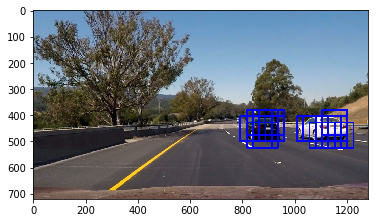

In [101]:
ystart = 380
ystop = 656
scale = 1.5


img = mpimg.imread('test_images/test6.jpg')
img_boxes = find_vehicles(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,vis=True)
draw_img = np.copy(img)
out_img = draw_boxes(img,img_boxes)

plt.imshow(out_img)
mpimg.imsave('output_images/test6_out.jpg',out_img, format = 'jpg', cmap = 'brg')

There are multiple boxes on each car. With defining add_heat() function, I was ablet to interate though all boxes and at the end draw just one box on each vehicle.

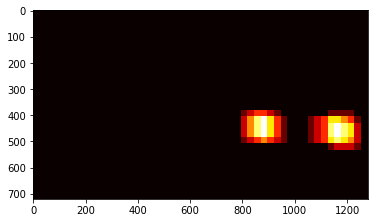

In [12]:
def add_heat(heatmap, box_list):
    # Makes a copy of image with all values equal to 0
    heatmap=np.zeros_like(test_image[:,:,0])
    # Iterates through list of bboxes
    for box in box_list:
        #print(box)
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
heated=add_heat(test_image,img_boxes)
plt.imshow(heated,cmap='hot')


In [13]:
def apply_threshold(heatmap, threshold):
    heated=np.copy(heatmap)
    # Zero out pixels below the threshold
    heated[heated <= threshold] = 0
    # Return thresholded map
    return heated
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #car.heatmap.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

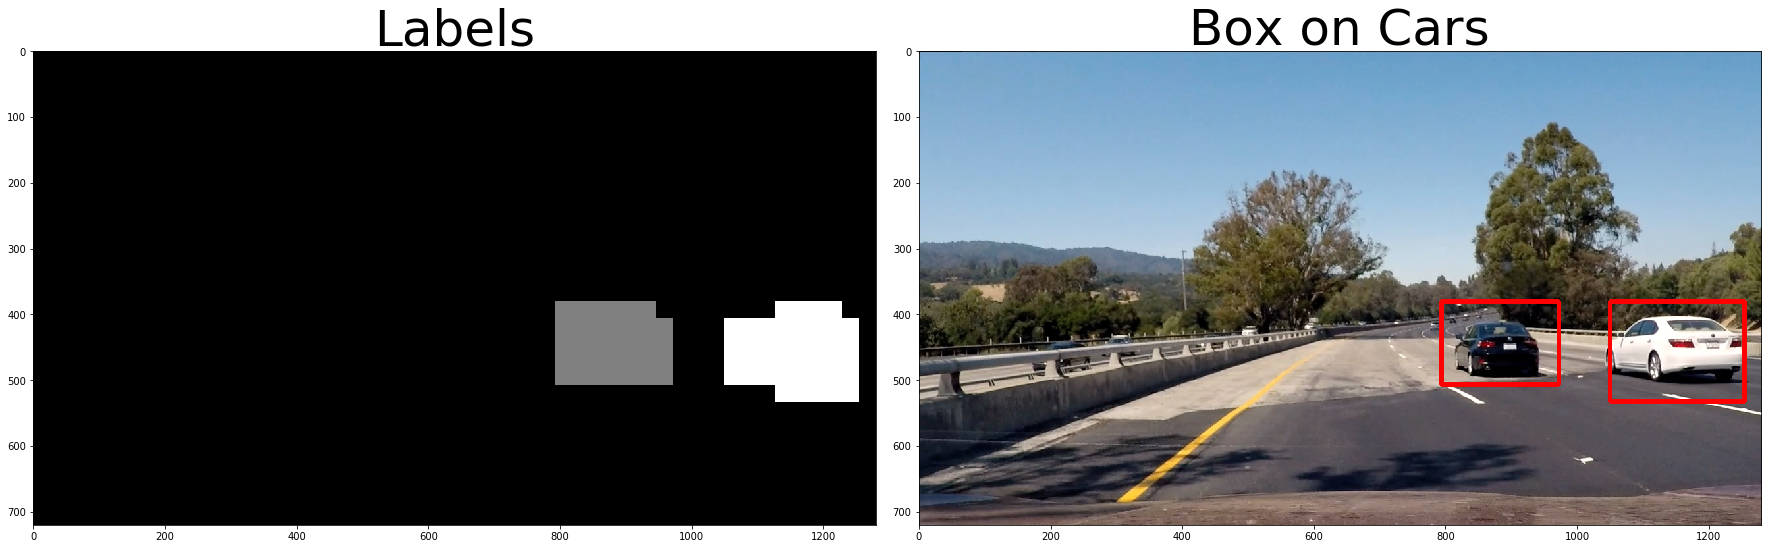

In [14]:
cooled=apply_threshold(heated,0.5)
labels = label(cooled)
final_image = draw_labeled_bboxes(np.copy(test_image), labels)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(labels[0], cmap='gray')
ax1.set_title('Labels', fontsize=50)
ax2.imshow(final_image)
ax2.set_title('Box on Cars', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Until now all the code does is to run and detect cars in single images. This procedure is only good when it is being applied to a video feed. 
 
To do so I created two types on filters. First with threshold of 1 the code filters frames that contain vehicles in. Then with applying a threshold of 8, after finding an image with a car in I look for cars in following 10 frames and if vehicle is being detected in 8 out of 10 frames, then the vehicle is being validated and will be marked with a box.

All these is acheived throught eh process_image() function.

In [15]:
class Vehicle():
    def __init__(self):
        self.heatmap=[]

In [16]:
car=Vehicle()
car.heatmap=[]

In [17]:
def process_image(img):
    # Initiaize lists
    heatmap=[]
    heated=np.zeros_like(img[:,:,0])
    # Sliding area vertical cordinate range
    ystart = 380
    ystop = 656
    # Scaling
    scale_all=[1,1.5,2]
    # Extracting features, finding vehicles, applying boxes and creating heat image and append them
    for scale in scale_all:
        out_boxes=find_vehicles(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heatmap.append(add_heat(img,out_boxes))
    # Adding all heatmaps in different scales
    heated=np.sum(heatmap,axis=0)
    # Thresholds on heatmaps
    heated_thresh=apply_threshold(heated,1)
    car.heatmap.append(heated_thresh)
    # Adds heatmaps for last 10 images
    heat_avg=np.sum(car.heatmap[-10:],axis=0)
    # Appling threshold 
    avg_cooled=apply_threshold(heat_avg,8)
    labels = label(avg_cooled)
    final_image = draw_labeled_bboxes(np.copy(img), labels)
    return final_image

And finally I rendered a video while running the vehicle detection code.
The output video is included in the submited repository. 

To accurately located each car, first I defined a function called add_heat() where in each input image first it detects zero values, then it adds all boxes on top of each other to creat a heated area on the image. When there is a hot spot on the output image, it is safe to assume that there is a car in that heated area and we can draw a single box to locate the vehicle.

In [18]:
# Makes sure heatmap is empty and there is no data from previous runs saved
car.heatmap=[]
# Output video Name
white_output = 'Project_Output_Final.mp4'
#Input Video
clip1 = VideoFileClip("project_video.mp4")
# Reads frame by frame and applies process image to each frame and outputs them as a video
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)
print('done')

[MoviePy] >>>> Building video Project_Output_Final.mp4
[MoviePy] Writing video Project_Output_Final.mp4


100%|█████████▉| 1260/1261 [23:42<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_Output_Final.mp4 

CPU times: user 32min 3s, sys: 16.4 s, total: 32min 20s
Wall time: 23min 42s
done


I found this method of locating each in each frame, generating a heatmap and at the end applying threshold on 8 out of 10 images to locate a vehicle in a video effective. However, there are few issues I noticed with this method. First this process is very slow. As seen above it took more than 23 minutes to render the output video. I know that in a real self driving car this has to happen in real time. Although in real time calculation we only work with 30 to 60 frames at each given second, not 1261 frames in one shot, but still this code is not efficient and fast enough to detect vehicles in real time.

My seconds issue with this code is the training set. With provided vehicle and not_vehicle images, I noticed that the model sometimes gets confused with high contrast shaded areas. Obviously one way to tackle this is to play with thresholds and scalings, but also I think with data augmentation, specially with creating more augmented data for high contrast regions, we should be able to generate more robust model in classifing vehicles.  